# Reinforcement Learning - Dynamic Programming
If you want to test/submit your solution **restart the kernel, run all cells and submit the dp_autograde.py file into codegrade.**

In [2]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
# All cells that start with %%execwritefile should be in dp_autograde.py file after running all cells.
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [3]:
%%execwritefile dp_autograde.py
import numpy as np
from collections import defaultdict

Overwriting dp_autograde.py


In [4]:
import matplotlib.pyplot as plt
import sys

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Policy Evaluation (1 point)
In this exercise we will evaluate a policy, e.g. find the value function of a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [7]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

Type:        GridworldEnv
String form: <GridworldEnv instance>
File:        d:\sergio\github_repos\uva_rlcourse_2023\gridworld.py
Docstring:  
Grid World environment from Sutton's Reinforcement Learning book chapter 4.
You are an agent on an MxN grid and your goal is to reach the terminal
state at the top left or the bottom right corner.

For example, a 4x4 grid looks as follows:

T  o  o  o
o  x  o  o
o  o  o  o
o  o  o  T

x is your position and T are the two terminal states.

You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
Actions going off the edge leave you in your current state.
You receive a reward of -1 at each step until you reach a terminal state.


In [5]:
# To have a quick look into the code
??env

Type:        GridworldEnv
String form: <GridworldEnv instance>
File:        d:\sergio\github_repos\uva_rlcourse_2023\gridworld.py
Source:     
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.

    For example, a 4x4 grid looks as follows:

    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T

    x is your position and T are the two terminal states.

    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argume

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [6]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [41]:
%%execwritefile -a dp_autograde.py

def policy_eval_v(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with an all 0 value function
    V = np.zeros(env.nS)
    # print(env.nS)
    # YOUR CODE HERE
    while True:
        delta = 0
        for state in range(env.nS):
            v_old = V[state]
            v_new = 0.0
            for action, action_prob in enumerate(policy[state]):
                for prob, next_state, reward, done in env.P[state][action]:
                    v_new += action_prob * (prob * (reward + discount_factor * V[next_state]))
            V[state] = v_new
            delta = max(delta, np.abs(v_new - v_old))
        if delta < theta:
            break

    return np.array(V)

Appending to dp_autograde.py


In [43]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval_v(random_policy, env)
assert V.shape == (env.nS)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

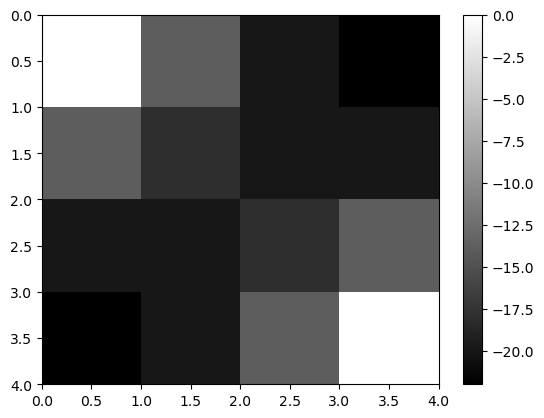

In [44]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [ ]:
%%execwritefile -a dp_autograde.py

def policy_iter_v(env, policy_eval_v=policy_eval_v, discount_factor=1.0):
    """
    Policy Iteration Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_v: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    # YOUR CODE HERE

    
    # raise NotImplementedError
    return policy, V

In [ ]:
# Let's see what it does
policy, v = policy_iter_v(env, policy_eval_v)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

---
## 3. Q-value Iteration (3 points)
In this exercise you will implement the value iteration algorithm. However, because this algorithm is quite similar to the ones you implemented previously, we will spice things up a bit and use Q-values instead. Thus instead of using Bellman optimality equations for V you will use Bellman equations for Q. 

In [ ]:
%%execwritefile -a dp_autograde.py

def value_iter_q(env, theta=0.0001, discount_factor=1.0):
    """
    Q-value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all state-action pairs.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, Q) of the optimal policy and the optimal Q-value function.        
    """
    
    # Start with an all 0 Q-value function
    Q = np.zeros((env.nS, env.nA))
    # YOUR CODE HERE
    raise NotImplementedError
    return policy, Q

In [ ]:
# Let's see what it does
policy, Q = value_iter_q(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Q Function:")
print(Q)
print("")

In [ ]:
# As you can see, the visualization of the Q function is quite clumsy and is not that easy to check 
# that all values make sense. However, you can easily create a V function from Q and policy to double
# check that the values are what you would expect.

If you want to test/submit your solution **restart the kernel, run all cells and submit the dp_autograde.py file into codegrade.**